<a href="https://colab.research.google.com/github/OscarRojasG/Experimentos-GPTValidator/blob/main/Framework_Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framework para experimentos GPTValidator

El objetivo de este framework consiste en proporcionar un conjunto de funciones previamente implementadas para facilitar la evaluación y comparación de prompts para el proyecto EvaluAI.

## Instrucciones de uso

Para la utilización del framework, se deben ejecutar **todas** las celdas de código. Una vez hecho esto, se creará una carpeta llamada **Experiments** con la siguiente estructura interna:

```
Experiments/
├── Datasets
├── Miniprompts
│   ├── Ejemplos
│   ├── Contexto
│   ├── Pregunta
│   ├── Respuesta
│   ├── Criteria
│   ├── Reflection
│   └── Feedback
└── Results
```

**Datasets**: Contiene datasets en formato *xlsx* con las siguientes columnas:

* Pregunta
* Respuesta real o contexto
* Respuesta del estudiante
* Evaluación manual (puntaje 0-3)

**Miniprompts**: Cada prompt se construye en base a una serie de miniprompts previamente definidos. Estos miniprompts deben ir en formato *txt* dentro de la carpeta correspondiente. Se pueden usar los strings `{context}`, `{question}` y `{answer}` como *placeholders* para reemplazar el contexto, la pregunta y la respuesta del estudiante respectivamente.

**Results**: Resultados de los experimentos en formato *json*.

## Funciones

### Experiment

`
experiment(dataset, sheet_name, column_data, prompt_data, criteria, repetitions, eval_function, eval_params=None)
`

Evalúa un prompt a partir de un dataset y retorna las métricas de evaluación.

Parámetros:

- **dataset** - Nombre del archivo xlsx con el dataset a utilizar.

- **sheet_name** - Nombre de la hoja donde se encuentran los datos.

- **column_data** - Diccionario para asociar las columnas obligatorias del dataset (clave) con su nombre real (valor). Debe tener las siguientes claves: *question*, *context*, *answer*, *real_eval*.

- **prompt_data** - Diccionario para especificar la estructura del prompt. Las claves almacenan el nombre del miniprompt al cual se hace referencia, por ejemplo, *examples*, *context*. El valor de cada clave corresponde al archivo *txt* donde se define el miniprompt a utilizar y que se encuentra en la carpeta del miniprompt correspondiente. La clave reservada *instructions* contiene un diccionario anidado donde se definen los miniprompts para las instrucciones del modelo (reflection, feedback, score).
<br>Se puede cambiar el orden de las claves y agregar o quitar miniprompts según sea necesario. Además, se puede usar el comodín \* como valor para evaluar todos los miniprompts que existan dentro de la carpeta.

- **criteria** - Lista con los criterios a evaluar, por ejemplo, *correctness*, *completeness*, *clarity*.

- **repetitions** - Cantidad de veces a repetir el experimento.

- **eval_function** - Método a utilizar para calcular los puntajes finales obtenidos por GPT. Puede ser *cuts* o *map*.

 - *cuts* pondera cada criterio y retorna valores discretos entre 0 y 3 dependiendo de los puntajes de corte.
 - *map* pondera cada criterio y mapea los puntajes a valores continuos entre 0 y 3.

- **eval_params** *(opcional)* - Lista con los parámetros a utilizar para el método *eval_function* elegido. Si es *None*, se calculan automáticamente los parámetros óptimos que minimicen el MSE. Dependiendo de *eval_function*, las listas deben contener los siguientes parámetros en orden:

 - *cuts* - $[w_1, w_2, ..., w_m, a, b, c]$ - donde $w_i$ corresponde a la ponderación del criterio $i$ especificado en la lista *criteria*, mientras que $a$, $b$ y $c$ son los puntajes de corte ordenados de menor a mayor.

 - *map* - $[w_1, w_2, ..., w_m, a, b]$ - donde $w_i$ corresponde a la ponderación del criterio $i$ especificado en la lista *criteria*, $a$ es el puntaje 0-10 equivalente a 1 en escala 0-3, $b$ es el puntaje 0-10 equivalente a 2 en escala 0-3.


### visualize_prompt

`
visualize_prompt(prompt_data)
`

Permite previsualizar un prompt antes de un experimento.

Parámetros:

- **prompt_data** - Diccionario para especificar la estructura del prompt.


### show_results

`
show_results(dir)
`

Imprime los resultados de un experimento previamente realizado.

Parámetros:

* **dir** - Nombre de la carpeta dentro de *Results/* que contiene los datos del experimento.









# Implementación

In [ ]:
!pip install openai==0.28 &> /dev/null
!pip install openai-multi-client &> /dev/null
!git clone https://github.com/rilianx/GPTEvaluator &> /dev/null

!curl -LO https://raw.githubusercontent.com/OscarRojasG/Experimentos-GPTValidator/main/Experiments.zip &> /dev/null
!unzip -n Experiments.zip &> /dev/null

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

gpt_dicts = [
    {
        'relevance': 10,
        'clarity': 8,
        'precision': 7
    },
    {
        'relevance': 3,
        'clarity': 6,
        'precision': 4
    }
]

real_scores = [3, 2]
criteria = ['relevance', 'clarity', 'precision']

class Optimizer():
    def __init__(self, gpt_dicts, real_scores, criteria):
        self.gpt_dicts = gpt_dicts
        self.real_scores = real_scores
        self.criteria = criteria

    def get_x(self):
        return [
            [gpt_dict[key] for key in self.criteria]
            for gpt_dict in self.gpt_dicts
        ]

    def get_weight_bounds(self):
        return [(0, 1) for _ in range(len(self.criteria))]


### Optimización de cortes y ponderaciones ###
class CutsOptimizer(Optimizer):
    def __init__(self, gpt_dicts, real_scores, criteria, eval_params):
        super().__init__(gpt_dicts, real_scores, criteria)

        if eval_params == None:
            bounds = self.get_weight_bounds() + [(1, 4), (4, 7), (7, 10)]
            result = differential_evolution(self.error, bounds, args=(self.get_x(), real_scores), seed=1, strategy='rand1exp', mutation=(0,1), recombination=1)
            self.params = result.x.tolist()
        else:
            self.params = eval_params

    def f(self, x, theta):
        score = np.dot(x, theta[:-3])
        y_pred = np.where(score > theta[-1], 3, np.where(score > theta[-2], 2, np.where(score > theta[-3], 1, 0)))
        return y_pred

    def error(self, theta, x, y):
        y_pred = self.f(x, theta)
        mse = np.mean((y - y_pred) ** 2)
        penalty = 1e6 * np.abs(np.sum(theta[:-3]) - 1)
        return mse + penalty

    def get_parameters(self):
        params = [round(p, 2) for p in self.params]
        return {
            "weights": dict(zip(criteria, params[:-2])),
            "cuts": params[-3:]
        }

    def get_scores(self):
        return self.f(self.get_x(), self.params).tolist()


####### Optimización mapeo de puntajes ########
class MapOptimizer(Optimizer):
    def __init__(self, gpt_dicts, real_scores, criteria, eval_params=None):
        super().__init__(gpt_dicts, real_scores, criteria)

        if eval_params == None:
            bounds = self.get_weight_bounds() + [(1, 9), (1, 9)]
            result = differential_evolution(self.error, bounds, args=(self.get_x(), real_scores), seed=1, strategy='rand1exp', mutation=(0,1), recombination=1)
            self.params = result.x.tolist()
        else:
            self.params = eval_params

    def inverse_map(self, y_pred, theta):
        a, b = theta[-2], theta[-1]
        def single_inverse_map(y):
            if y <= a:
                return y / a
            elif a < y <= b:
                return 1 + (y - a) / (b - a)
            else:
                return min(10, 2 + (y - b) / (10 - b))

        return np.array([single_inverse_map(y) for y in y_pred])

    def f(self, x, theta):
        return np.dot(x, theta[:-2])

    def error(self, theta, x, y):
        y_pred = self.f(x, theta)
        mse = np.sum((y - self.inverse_map(y_pred, theta)) ** 2)
        penalty = 1e6 * np.abs(np.sum(theta[:-2]) - 1)
        a, b = theta[-2], theta[-1]
        if a > b: penalty += (a - b) * 1e5
        return mse + penalty

    def get_parameters(self):
        params = [round(p, 2) for p in self.params]
        return {
            "weights": dict(zip(self.criteria, params[:-2])),
            "a": params[-2],
            "b": params[-1]
        }

    def get_scores(self):
        y_pred = self.f(self.get_x(), self.params)
        return [round(n, 2) for n in self.inverse_map(y_pred, self.params)]


# Función para convertir puntajes GPT a puntajes reales entre 0 y 3
def convert_scores(gpt_dicts, real_scores, criteria, eval_function, eval_params=None):
    if eval_function == "map":
        optimizer = MapOptimizer(gpt_dicts, real_scores, criteria, eval_params)
    if eval_function == "cuts":
        optimizer = CutsOptimizer(gpt_dicts, real_scores, criteria, eval_params)

    return optimizer.get_scores(), optimizer.get_parameters()

In [ ]:
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score
from GPTEvaluator.GPTEvaluator import chat_gpt_multiple
from openai_multi_client import OpenAIMultiClient
from datetime import datetime, timedelta
from google.colab import userdata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import openai
import getpass
import json
import copy
import re
import os

openai.api_key = userdata.get('api_key')

# Retorna un diccionario con el contenido de cada miniprompt
def read_miniprompts(data):
    def read_file(folder, filename):
        path = f"Experiments/Miniprompts/{folder}/{filename}"
        try:
            return open(path, 'r', encoding='utf-8').read()
        except:
            raise Exception(f"Error: El archivo {path} no existe")

    mdata = copy.deepcopy(data)
    for i, (key, value) in enumerate(data.items()):
        if key == "instructions":
            for j, (key2, value2) in enumerate(data[key].items()):
                mdata[key][key2] = read_file(key2, value2)
        else:
            mdata[key] = read_file(key, value)

    return mdata

# Genera un prompt a partir de un diccionario con el contenido de cada miniprompt
def generate_prompt(data):
    prompt = ""
    n = len(data.items())

    for i, (key, value) in enumerate(data.items()):
        if key == "instructions":
            prompt += "Instructions: \n"
            for j, (key2, value2) in enumerate(data[key].items()):
                prompt += value2 + "\n\n"
        else:
            prompt += value
            if i < n-1:
                prompt += "\n\n"

    return prompt

# Carga un dataset a partir de un archivo xlsx y valida sus columnas
def load_dataset(filename, sheet_name, column_data):
  path = f"Experiments/Datasets/{filename}"
  df = pd.read_excel(path, sheet_name=sheet_name)

  mandatory_cols = ["context", "question", "answer", "real_eval"]
  for key in mandatory_cols:
    if key not in column_data.keys():
      raise Exception(f"Error: Debe especificar la columna para la variable {key}")

    value = column_data[key]
    if value not in df.columns:
      raise Exception(f"Error: La columna {value} no existe")

    df = df.rename(columns={value: key})

  return df

# Genera las respuestas con ChatGPT
def eval_gpt(df, prompt):
  api = OpenAIMultiClient(endpoint="chats", data_template={"model": "gpt-3.5-turbo", "temperature": 0.2, "n": 1, "timeout":10}, concurrency=50, wait_interval=1, max_retries=3, retry_max=10, retry_multiplier=1)

  texts = []
  for i, row in df.iterrows():
    text = prompt.format(Question=row['question'], Answer=row['answer'], Context=row['context'])
    texts.append(text)

  answers_gpt = chat_gpt_multiple(api, texts)
  return answers_gpt

# Convierte la respuesta de GPT en un diccionario
def get_gpt_dicts(answers_gpt):
    pattern = r'\{[^{}]+\}'

    gpt_dicts = []
    for answer_gpt in answers_gpt:
        try:
            answer = re.findall(pattern, answer_gpt[0])[0]
            gpt_dicts.append(eval(answer))
        except Exception as e:
            print(f"Error al extraer diccionario. Respuesta GPT: \n{answer_gpt[0]}\n\n")
            gpt_dicts.append(None)

    return gpt_dicts

# Obtiene los puntajes reales de un dataset
def get_real_scores(df):
    return df['real_eval'].tolist()

# Calcula las métricas de evaluación
def get_stats(real_scores, gpt_scores, eval_function):
    if eval_function == "cuts":
        stats = {
            "confusion_matrix": confusion_matrix(real_scores, gpt_scores, labels=[0,1,2,3]).tolist(),
            "mse": round(mean_squared_error(real_scores, gpt_scores), 2),
            "mae": round(mean_absolute_error(real_scores, gpt_scores), 2),
            "r2": round(r2_score(real_scores, gpt_scores), 2),
            "accuracy": round(accuracy_score(real_scores, gpt_scores), 2),
            "sample_size": len(real_scores)
        }
    elif eval_function == "map":
        stats = {
            "mse": round(mean_squared_error(real_scores, gpt_scores), 2),
            "mae": round(mean_absolute_error(real_scores, gpt_scores), 2),
            "r2": round(r2_score(real_scores, gpt_scores), 2),
            "sample_size": len(real_scores)
        }

    return stats

def save_results(dataset, dataset_size, prompt, results, eval_function, filepath):
  with open(filepath, 'w', encoding='utf-8') as file:
    data = {
        "dataset_name": dataset,
        "dataset_size": dataset_size,
        "prompt": prompt['prompt'],
        "field": prompt['field'],
        "file": prompt['file'],
        "eval_function": eval_function,
        "results": results
    }
    json.dump(data, file, ensure_ascii=False)

def remove_invalid_samples(gpt_dicts, real_scores):
    for i in reversed(range(len(gpt_dicts))):
        if gpt_dicts[i] == None:
            gpt_dicts.pop(i)
            real_scores.pop(i)

# Evalúa un prompt y retorna las estadísticas obtenidas
def evaluate_prompt(df, prompt, criteria, eval_function, eval_params):
    try:
        answers_gpt = eval_gpt(df, prompt)
        real_scores = get_real_scores(df)
        gpt_dicts = get_gpt_dicts(answers_gpt)
        remove_invalid_samples(gpt_dicts, real_scores)
        gpt_scores, eval_params = convert_scores(gpt_dicts, real_scores, criteria, eval_function, eval_params)
        stats = get_stats(real_scores, gpt_scores, eval_function)

        return {
            'real_scores': real_scores,
            'gpt_scores': gpt_scores,
            'params': eval_params,
            'stats': stats
        }
    except Exception as e:
        print(e)

# Evalúa un prompt para N repeticiones
def evaluate_prompt_n(df, prompt, criteria, repetitions, eval_function, eval_params):
    result_list = []

    for _ in range(repetitions):
        result = evaluate_prompt(df, prompt, criteria, eval_function, eval_params)
        result_list.append(result)

    return result_list

# Retorna una lista con la metadata necesaria para generar cada prompt
def transform_prompt_data(prompt_data):
    folder_key = None
    instruction = False
    update_count = 0

    for key, value in prompt_data.items():
        if key == "instructions":
            for key2, value2 in prompt_data[key].items():
                if value2 == "*":
                    folder_key = key2
                    instruction = True
                    update_count += 1

        elif value == "*":
            folder_key = key
            update_count += 1

    if update_count == 0: # Sin carpetas, evaluar archivos directamente
        return [{'data': prompt_data, 'field': None, 'file': None}]
    elif update_count > 1:
        raise Exception(f"Error: Solo una carpeta a la vez como máximo")

    # Recorrer archivos en la carpeta y generar lista de metadatos
    prompt_data_list = []
    path = f"Experiments/Miniprompts/{folder_key}"
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            prompt_data_copy = copy.deepcopy(prompt_data)
            if instruction:
                prompt_data_copy["instructions"][folder_key] = file
            else:
                prompt_data_copy[folder_key] = file

            prompt_data_list.append({'data': prompt_data_copy, 'field_in_instructions': instruction, 'field': folder_key, 'file': file})

    return prompt_data_list

# Genera los prompts a partir de un objeto prompt_data
def generate_prompts(prompt_data):
    prompt_data_list = transform_prompt_data(prompt_data)

    for prompt_data in prompt_data_list:
        miniprompt_data = read_miniprompts(prompt_data['data'])
        prompt_data['prompt'] = generate_prompt(miniprompt_data)

    return prompt_data_list

# Muestra un histograma a partir de la frecuencia de puntajes
def show_histogram(real_counts, pred_counts):
    bins = np.arange(-0.5, 4, 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    width = 0.35
    plt.bar(bin_centers - width/2, real_counts, width=width, label='Real Eval', align='center')
    plt.bar(bin_centers + width/2, pred_counts, width=width, label='GPT Eval', align='center')

    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.title('Histograma')
    plt.legend()
    plt.show()

# Muestra resultados del experimento
def show_results(dir):
    print(f"{'':<20} {'Métrica':<15} {'Media':<15} Desviación estándar\n")
    for filename in sorted(os.listdir(dir)):
        path = os.path.join(dir, filename)
        if os.path.isfile(path):
            file = open(path, 'r', encoding='utf-8')
            data = json.load(file)
            file.close()

            if data['eval_function'] == "cuts":
                show_results_cuts(data)
            elif data['eval_function'] == "map":
                show_results_map(data)

# Muestra resultados de un experimento usando la función cuts
def show_results_cuts(data):
    maes = []
    mses = []
    r2s = []
    accuracies = []
    matrices = []

    for result in data['results']:
        stats = result['stats']
        maes.append(stats['mae'])
        mses.append(stats['mse'])
        r2s.append(stats['r2'])
        accuracies.append(stats['accuracy'])
        matrices.append(stats['confusion_matrix'])

    prompt_file = data['file']
    if prompt_file == None: prompt_file = "Prompt"

    print(f"{f'{prompt_file}':<20} {'MAE':<15} {round(np.mean(maes),2):<15} {round(np.std(maes),2):<15}")
    print(f"{'':<20} {'MSE':<15} {round(np.mean(mses),2):<15} {round(np.std(mses),2):<15}")
    print(f"{'':<20} {'R2':<15} {round(np.mean(r2s),2):<15} {round(np.std(r2s),2):<15}")
    print(f"{'':<20} {'Accuracy':<15} {round(np.mean(accuracies),2):<15} {round(np.std(accuracies),2):<15}\n")

    matrices_np = np.array(matrices)
    matrix_sum = np.sum(matrices_np, axis=0)
    formatted_matrix_sum = str(matrix_sum).split('\n')
    print(f"{'':<20} {'Matriz confusión'}")
    for row in formatted_matrix_sum:
        print(f"{'':<20} {row}")
    print()

    real_counts = [sum(row) for row in matrix_sum]
    pred_counts = [sum(col) for col in list(zip(*matrix_sum))]
    show_histogram(real_counts, pred_counts)
    print()

# Muestra resultados de un experimento usando la función map
def show_results_map(data):
    maes = []
    mses = []
    r2s = []
    real_scores = []
    gpt_scores = []

    for result in data['results']:
        stats = result['stats']
        maes.append(stats['mae'])
        mses.append(stats['mse'])
        r2s.append(stats['r2'])
        real_scores.append(result['real_scores'])
        gpt_scores.append(result['gpt_scores'])

    prompt_file = data['file']
    if prompt_file == None: prompt_file = "Prompt"

    print(f"{f'{prompt_file}':<20} {'MAE':<15} {round(np.mean(maes),2):<15} {round(np.std(maes),2):<15}")
    print(f"{'':<20} {'MSE':<15} {round(np.mean(mses),2):<15} {round(np.std(mses),2):<15}")
    print(f"{'':<20} {'R2':<15} {round(np.mean(r2s),2):<15} {round(np.std(r2s),2):<15}")

    idx = np.argsort(mses)[len(mses) // 2]
    real_scores = real_scores[idx]
    gpt_scores = gpt_scores[idx]

    groups = {v: [a for a, b in zip(gpt_scores, real_scores) if b == v] for v in set(real_scores)}
    plt.boxplot(groups.values(), labels=groups.keys())
    plt.title('Distribución de puntajes GPT')
    plt.xlabel('Puntaje real')
    plt.ylabel('Puntaje GPT')

    print()


# Evalúa varios prompts a la vez con N repeticiones
def experiment(dataset, sheet_name, column_data, prompt_data, criteria, repetitions, eval_function, eval_params=None):
    def create_dir():
        date = datetime.now() - timedelta(hours=4)
        formatted_date = date.strftime('%Y%m%d-%H%M')

        dir = f"Experiments/Results/{formatted_date}"
        if not os.path.exists(dir):
            os.makedirs(dir)
        return dir

    valid_functions = ["cuts", "map"]
    if eval_function not in valid_functions:
        raise Exception(f"Error: El parámetro eval_function debe ser 'cuts' o 'map'")

    visualize_prompt(prompt_data)

    df = load_dataset(dataset, sheet_name, column_data)
    prompts = generate_prompts(prompt_data)
    dir = create_dir()

    for i, prompt in enumerate(prompts):
        if prompt['file']:
            filename = os.path.splitext(prompt['file'])[0]
        else:
            filename = "results"

        filepath = f"{dir}/{filename}.json"
        result_list = evaluate_prompt_n(df, prompt['prompt'], criteria, repetitions, eval_function, eval_params)
        save_results(dataset, len(df), prompt, result_list, eval_function, filepath)

    print('\n')
    show_results(dir)

# Muestra el prompt generado a partir de un diccionario prompt_data
def visualize_prompt(prompt_data):
    prompt_data_list = transform_prompt_data(prompt_data)
    miniprompt_data = read_miniprompts(prompt_data_list[0]['data'])

    if len(prompt_data_list) == 1:
        print(generate_prompt(miniprompt_data))
    else:
        prompt_data = prompt_data_list[0]
        if prompt_data['field_in_instructions']:
            miniprompt_data['instructions'][prompt_data['field']] = f"{{{prompt_data['field']}}}"
        else:
            miniprompt_data[prompt_data['field']] = f"{{{prompt_data['field']}}}"
        print(generate_prompt(miniprompt_data))


**Examples:**
Q: ¿Cómo se podría implementar un historial de navegación web usando dos pilas? El historial debe permitir ir hacia atrás y adelante con las páginas previamente visitadas. Describa un algoritmo.
**Insatisfactory Answer**: Usamos dos pilas para ir hacia adelante y hacia atrás en el historial.
(Score: 0)

Q: ¿Por qué el acceso a un elemento específico en un arreglo es O(1), es decir, no depende de la cantidad de datos?
**Insatisfactory Answer**: El acceso es O(1) por que toma un tiempo constante y no depende de la cantidad de datos.
(Score: 0)

Q: ¿Cuando se recomienda utilizar arreglos en vez de listas enlazadas? Haga referencia a complejidades temporales en su explicación.
**Insatisfactory Answer**: Un arreglo es recomendable en determinadas situaciones, mientras que la lista enlazada en otras.
Feedback: La respuesta del estudiante es incorrecta ya que no proporciona información nueva y simplemente reformula la pregunta sin agregar profundidad o claridad.
(Score: 0)

Q: ¿

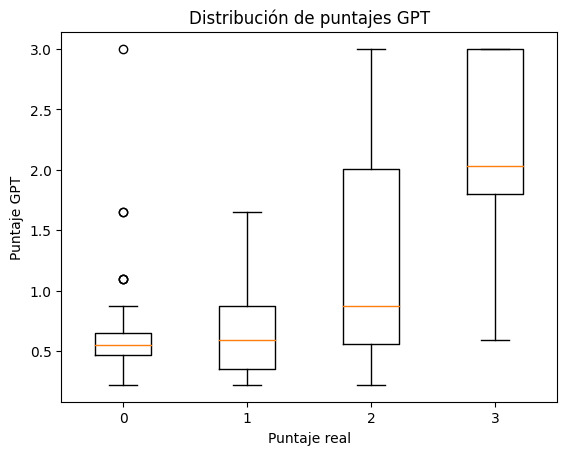

In [ ]:
prompt_data = {
    "examples": "examples_3.txt",
    "context": "context_1.txt",
    "question": "question_1.txt",
    "answer": "answer_1.txt",
    "instructions": {
        "reflection": "reflection_1.txt",
        "feedback": "feedback_1.txt",
        "score": "score_1.txt",
    },
    "criteria": "criteria_1.txt",
    "output": "output_1.txt"
}

column_data = {
    "context": "Contexto",
    "question": "Pregunta",
    "answer": "Respuesta",
    "real_eval": "EvalProfe"
}

criteria = ["correctness", "completeness", "clarity"]

experiment(
    dataset="control2_2024-1.xlsx",
    sheet_name="C2-claim",
    column_data=column_data,
    prompt_data=prompt_data,
    criteria=criteria,
    repetitions=1,
    eval_function="map"
)

In [ ]:
# Descargar carpeta
!zip -r Experiments.zip Experiments/

from google.colab import files
files.download("/content/Experiments.zip")

updating: Experiments/Datasets/ (stored 0%)
updating: Experiments/Datasets/control2_2024-1.xlsx (deflated 6%)
updating: Experiments/Datasets/test.xlsx (deflated 22%)
updating: Experiments/Miniprompts/ (stored 0%)
updating: Experiments/Miniprompts/answer/ (stored 0%)
updating: Experiments/Miniprompts/answer/answer_1.txt (deflated 10%)
updating: Experiments/Miniprompts/context/ (stored 0%)
updating: Experiments/Miniprompts/context/context_1.txt (deflated 6%)
updating: Experiments/Miniprompts/criteria/ (stored 0%)
updating: Experiments/Miniprompts/criteria/criteria_1.txt (deflated 12%)
updating: Experiments/Miniprompts/examples/ (stored 0%)
updating: Experiments/Miniprompts/examples/examples_1.txt (deflated 50%)
updating: Experiments/Miniprompts/examples/examples_2.txt (deflated 48%)
updating: Experiments/Miniprompts/feedback/ (stored 0%)
updating: Experiments/Miniprompts/feedback/feedback_1.txt (deflated 45%)
updating: Experiments/Miniprompts/output/ (stored 0%)
updating: Experiments/Min

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                     Métrica         Media           Desviación estándar

examples_1.txt       MAE             0.696           0.011          
                     MSE             0.924           0.032          
                     R2              0.204           0.028          
                     Accuracy        0.415           0.023          

                     Matriz confusión
                     [[35 78 27  1]
                      [13 55 10  0]
                      [ 1 34 31 12]
                      [ 0  8 16 21]]



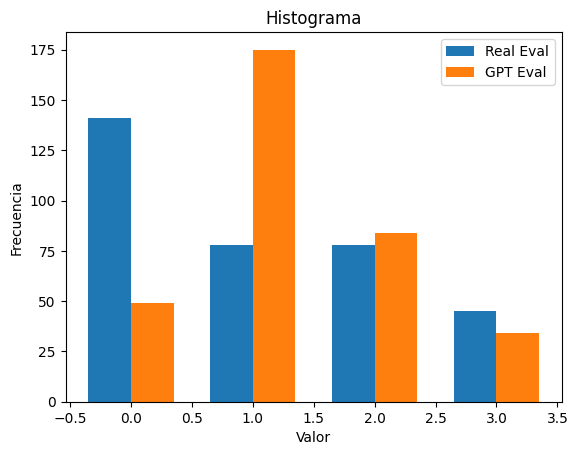


examples_2.txt       MAE             0.673           0.03           
                     MSE             0.871           0.05           
                     R2              0.249           0.043          
                     Accuracy        0.427           0.048          

                     Matriz confusión
                     [[40 78 23  0]
                      [15 54  8  1]
                      [ 1 33 38  6]
                      [ 0  9 22 14]]



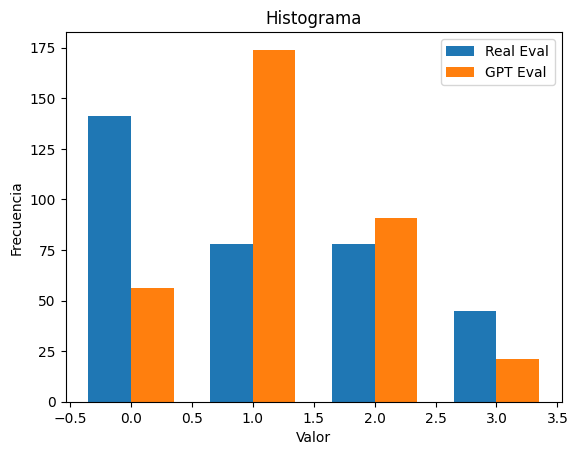


examples_3.txt       MAE             0.687           0.027          
                     MSE             0.868           0.061          
                     R2              0.252           0.053          
                     Accuracy        0.401           0.015          

                     Matriz confusión
                     [[39 84 17  1]
                      [15 54  8  1]
                      [ 0 38 31  9]
                      [ 0 10 22 13]]



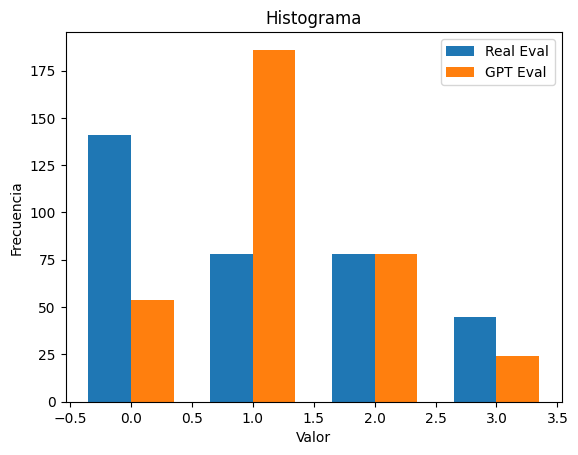

In [ ]:
show_results("Experiments/Results/20240622-1520")